In [1]:
import sys
import pandas as pd
import numpy as np

# Define a random seed for reproducibility
seed = 0
np.random.seed(seed)

import sklearn
import xgboost
import keras
import tensorflow as tf

import os
import pickle
import matplotlib.pyplot as plt


print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('XGBoost: {}'.format(xgboost.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
XGBoost: 1.1.1
Keras: 2.3.1


In [31]:
def load_train_and_test(path):

    """Loads training features, training labels, testing features, and testing features
    Parameters:
        path (str) -- a single directory path containing all four datasets
    """

    train_features = pd.read_csv(path + 'train_features.csv', index_col=0)
    train_labels = pd.read_csv(path + 'train_labels.csv', index_col=0)
    test_features = pd.read_csv(path + 'test_features.csv', index_col=0)
    test_labels = pd.read_csv(path + 'test_labels.csv', index_col=0)

    return train_features, train_labels.values.ravel(), test_features, test_labels.values.ravel()

X_train, Y_train, X_test, Y_test = load_train_and_test('../data/split/')

In [37]:
# load all optimized models from the models folder

dirName = '../models/'

fileList = list()
dirList = list()

for (dirpath, dirnames, filenames) in os. walk(dirName):
    for file in filenames:
        if '.sav' in file:
            fileList.append(os.path. join(dirpath, file))

modelList = list()

for file in fileList:
    model = pickle.load(open(file, 'rb'))
    modelList.append(model)

In [38]:
def bootstrap_roc_curves(model, X_test, Y_test):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = [round(x,2) for x in lr_probs[:, 1]]
    
    n_bootstraps = 1000
    rng_seed = 42# control reproducibility
    bootstrapped_scores = []
    fprList = []
    tprList = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(lr_probs), len(lr_probs))
        if len(np.unique(np.array(Y_test)[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        labels = np.array(Y_test)[indices]
        predictions = np.array(lr_probs)[indices]

        # calculate scores and curve
        bootstrapped_scores.append(sklearn.metrics.roc_auc_score(labels, predictions))
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(labels, predictions, drop_intermediate=True)
        
        fprList.append(lr_fpr)
        tprList.append(lr_tpr)
    
    return fprList, tprList, bootstrapped_scores

In [41]:
import matplotlib.pyplot as plt

def generate_roc_curves(models, names, X_test, Y_test, bootstrap=True):
    
    plt.figure(figsize=(10,10))
    cmap = plt.get_cmap('tab10')
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(Y_test))]
    
    aucList = []
    
    for i,model in enumerate(models):
        
        # predict probabilities
        lr_probs = model.predict_proba(X_test)
        
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        
        # calculate scores and curve
        lr_auc = sklearn.metrics.roc_auc_score(Y_test, lr_probs)
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(Y_test, lr_probs)
        
        if bootstrap:
            fpr, tpr, scores = bootstrap_roc_curves(model, X_test, Y_test)
            
            scores.sort()
            sorted = np.array(scores)
        
        aucList.append([lr_auc, sorted[25], sorted[975]])
        
        # plot the roc curve for the model
        plt.plot(lr_fpr, lr_tpr, color=cmap(0.1*i), marker='', label='{} (AUC = {} (95% CI {} to {}))'.format(names[i], round(lr_auc,3), round(sorted[25], 3), round(sorted[975],3)))
    
    # plot the roc curve for the no skill model
    ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(Y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black', label='No Skill (AUC = 0.500)')
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # title
    plt.title('ROC AUC Scores by Algorithm Type')
    # show the legend
    plt.legend(loc = 'lower right')
    
    #save the figure
    #plt.savefig('../reports/figures/ROC_AUC_utah_pts.png')
    
    # show the plot
    plt.show()
    
    return aucList

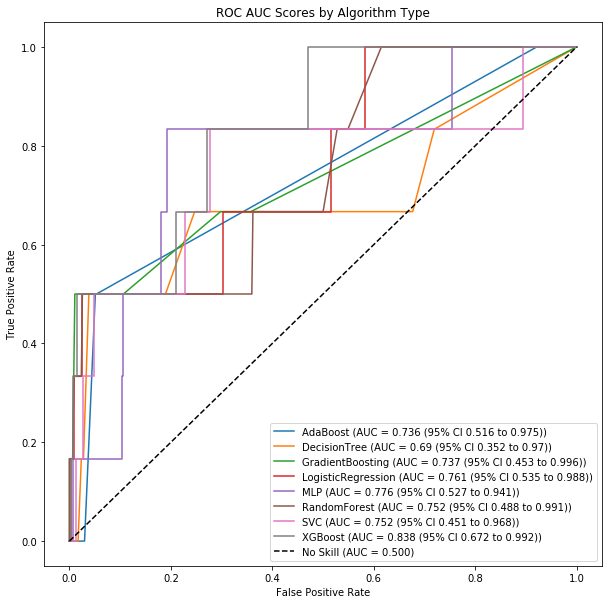

In [42]:
index = [file.split('/')[-1].rstrip('.sav') for file in fileList]
aucs = generate_roc_curves(modelList, index, X_test, Y_test)

<function matplotlib.pyplot.show(*args, **kw)>

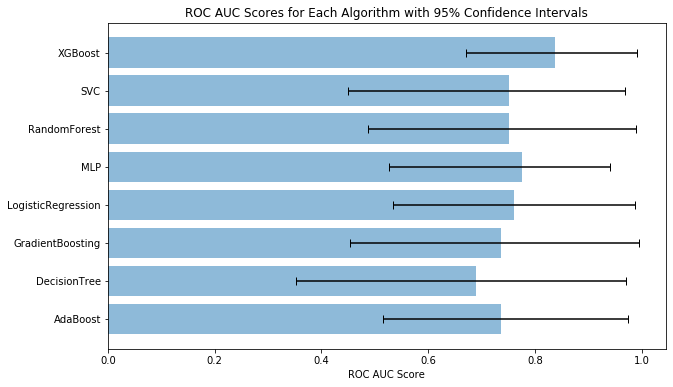

In [43]:
pos = np.arange(len(aucs))
lower = [x[0] - x[1] for x in aucs]
upper = [x[2] - x[0] for x in aucs]
xerr = [lower, upper]

plt.figure(figsize=(10,6))
rects = plt.barh(pos, [x[0] for x in aucs],
                 align='center',
                 height=0.8,
                 tick_label=index,
                 xerr = xerr,
                 capsize = 4.0,
                 alpha = 0.5
                )
plt.xlabel("ROC AUC Score")
plt.title("ROC AUC Scores for Each Algorithm with 95% Confidence Intervals")
#plt.savefig('../reports/figures/roc_bar_graph.png')
plt.show

In [44]:
from sklearn.metrics import classification_report

def scores(Y_test, y_pred, probs):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(Y_test, y_pred).ravel()
    
    print('Confusion Matrix:')
    data = {'y_Actual':    Y_test,
        'y_Predicted': y_pred
        }
    
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    print (confusion_matrix)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    PPV = tp / (tp + fp)
    NPV = tn / (tn + fn)

    print('\nSensitivity: {}'.format(sensitivity))
    print('Specificity: {}'.format(specificity))
    print('PPV: {}'.format(PPV))
    print('NPV: {}'.format(NPV))
    
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(Y_test, y_pred, average='binary')
    auc = sklearn.metrics.roc_auc_score(Y_test, probs[:,1])

    return sensitivity, specificity, PPV, NPV, f1, auc

scoresList = []

for model in modelList:
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    print(model)
    print(classification_report(Y_test, y_pred))
    scoresList.append(np.array(scores(Y_test, y_pred, probs)))
    print('\n')

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=1.9077286439952401, n_estimators=10,
                   random_state=None)
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       470
           1       0.00      0.00      0.00         6

    accuracy                           0.96       476
   macro avg       0.49      0.49      0.49       476
weighted avg       0.97      0.96      0.97       476

Confusion Matrix:
Predicted    0   1
Actual            
0          456  14
1            6   0

Sensitivity: 0.0
Specificity: 0.9702127659574468
PPV: 0.0
NPV: 0.987012987012987


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.00039105274699932635,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_sa

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

           0       0.99      0.95      0.97       470
           1       0.04      0.17      0.06         6

    accuracy                           0.94       476
   macro avg       0.51      0.56      0.51       476
weighted avg       0.98      0.94      0.96       476

Confusion Matrix:
Predicted    0   1
Actual            
0          445  25
1            5   1

Sensitivity: 0.16666666666666666
Specificity: 0.9468085106382979
PPV: 0.038461538461538464
NPV: 0.9888888888888889


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.019347849800475,
                       min_impurity_split=None, min_samples_leaf=8,
                       min_samples_split=2,
                       min_weight_fraction_leaf=0.038305700292

In [45]:
def bootstrap_scores(model, X_test, Y_test):
    
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    preds = model.predict(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = [round(x,2) for x in lr_probs[:, 1]]
    
    n_bootstraps = 1000
    rng_seed = 42# control reproducibility
    sensitivityList = []
    specificityList = []
    PPVList = []
    NPVList = []
    PrecisionList = []
    RecallList = []
    f1List = []
    aucList = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(lr_probs), len(lr_probs))
        if len(np.unique(np.array(Y_test)[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        labels = np.array(Y_test)[indices]
        predictions = np.array(lr_probs)[indices]
        preds_class = np.array(preds)[indices]

        # calculate scores and curve
        precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels, preds_class, average='binary')
        
        PrecisionList.append(precision)
        RecallList.append(recall)
        f1List.append(f1)
        
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(labels, preds_class).ravel()
        
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        PPV = tp / (tp + fp)
        NPV = tn / (tn + fn)
        
        sensitivityList.append(sensitivity)
        specificityList.append(specificity)
        PPVList.append(PPV)
        NPVList.append(NPV)
        
        aucList.append(sklearn.metrics.roc_auc_score(labels, predictions))
    
    return sensitivityList, specificityList, PPVList, NPVList, PrecisionList, RecallList, f1List, aucList

In [46]:
table = []
for i, model in enumerate(modelList):
    sens, spec, ppv, npv, prec, recall, f1, auc = bootstrap_scores(model, X_test, Y_test)
    
    sens.sort()
    spec.sort()
    ppv.sort()
    npv.sort()
    f1.sort()
    auc.sort()
    
    intervals = [sens, spec, ppv, npv, f1, auc]   
    
    row = []
    for j, value in enumerate(scoresList[i]):
        text = '{:.2f} ({:.2f} to {:.2f})'.format(value, intervals[j][25], intervals[j][975])
        row.append(text)
    
    table.append(row)

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\sklearn\metrics\_classification.py:1272: 

In [47]:
ci_df = pd.DataFrame(table, columns=['Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-score', 'AUC'], index=index)


def bold_max(data, weight='bold'):
    '''
    bold the maximum in a Series or DataFrame
    '''
    attr = 'font-weight: {}'.format(weight)
    
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
ci_df.style.apply(bold_max)

,Sensitivity,Specificity,PPV,NPV,F1-score,AUC
AdaBoost,0.00 (0.00 to 0.00),0.97 (0.96 to 0.99),0.00 (0.00 to 0.00),0.99 (0.98 to 1.00),0.00 (0.00 to 0.00),0.74 (0.52 to 0.97)
DecisionTree,0.67 (0.25 to 1.00),0.71 (0.67 to 0.75),0.03 (0.01 to 0.06),0.99 (0.98 to 1.00),0.05 (0.01 to 0.11),0.69 (0.35 to 0.97)
GradientBoosting,0.00 (0.00 to 0.00),1.00 (1.00 to 1.00),nan (nan to nan),0.99 (0.98 to 1.00),0.00 (0.00 to 0.00),0.74 (0.45 to 1.00)
LogisticRegression,0.50 (0.00 to 1.00),0.70 (0.66 to 0.74),0.02 (0.00 to 0.05),0.99 (0.98 to 1.00),0.04 (0.00 to 0.09),0.76 (0.53 to 0.99)
MLP,0.17 (0.00 to 0.60),0.95 (0.93 to 0.97),0.04 (0.00 to 0.13),0.99 (0.98 to 1.00),0.06 (0.00 to 0.21),0.78 (0.53 to 0.94)
RandomForest,0.50 (0.00 to 1.00),0.84 (0.81 to 0.88),0.04 (0.00 to 0.09),0.99 (0.98 to 1.00),0.07 (0.00 to 0.16),0.75 (0.49 to 0.99)
SVC,0.50 (0.00 to 1.00),0.79 (0.76 to 0.83),0.03 (0.00 to 0.07),0.99 (0.98 to 1.00),0.06 (0.00 to 0.12),0.75 (0.45 to 0.97)
XGBoost,0.83 (0.50 to 1.00),0.57 (0.53 to 0.62),0.02 (0.00 to 0.05),1.00 (0.99 to 1.00),0.05 (0.01 to 0.09),0.84 (0.67 to 0.99)


In [48]:
def getTableHTML(df, string=False):
    
    """
    Get a Jupyter like html of pandas dataframe
    
    """

    styles = [
        #table properties
        dict(selector=" ", 
             props=[("margin","0"),
                    ("font-family",'"Helvetica", "Arial", sans-serif'),
                    ("border-collapse", "collapse"),
                    ("border","none"),
                    #("border", "2px solid #ccf")
                    ("column-gap", "400px")
                       ]),

        #background shading
        dict(selector="tbody tr:nth-child(even)",
             props=[("background-color", "#fff")]),
        dict(selector="tbody tr:nth-child(odd)",
             props=[("background-color", "#eee")]),

        #cell spacing
        dict(selector="td", 
             props=[("padding", ".4em")]),

        #header cell properties
        dict(selector="th", 
             props=[("font-size", "100%"),
                    ("text-align", "center")]),
    ]
    
    if not string:
        out = (df.style.apply(bold_max).format("{:.3f}").set_table_styles(styles)).render()
    else:
        out = (df.style.apply(bold_max).set_table_styles(styles)).render()
        
    return out

In [49]:
ci_html = getTableHTML(ci_df, string=True)

In [50]:
no_ci_df = pd.DataFrame(scoresList, columns=['Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-score', 'AUC'], index=index)

no_ci_html = getTableHTML(no_ci_df)

html = no_ci_html + "<br>" + "<br>" + ci_html

## OUTPUT AN HTML FILE
with open('../reports/figures/performance_characteristics_utah_test.html', 'w') as f:
    f.write(html)

In [100]:
def plot_bar_score(scores, name):
    
    pos = np.arange(len(scores))
    lower = [x[0] - x[1] for x in scores]
    upper = [x[2] - x[0] for x in scores]
    xerr = [lower, upper]
    

    plt.figure(figsize=(10,6))
    rects = plt.barh(pos, [x[0] for x in scores],
                     align='center',
                     height=0.8,
                     tick_label=index,
                     xerr = xerr,
                     capsize = 4.0,
                     alpha = 0.5
                    )
    plt.xlabel("{} Score".format(name))
    plt.title("{} Scores for Each Algorithm with 95% Confidence Intervals".format(name))
    plt.tight_layout()
    plt.savefig('../reports/figures/{}_bar_graph.png'.format(name))
    plt.show

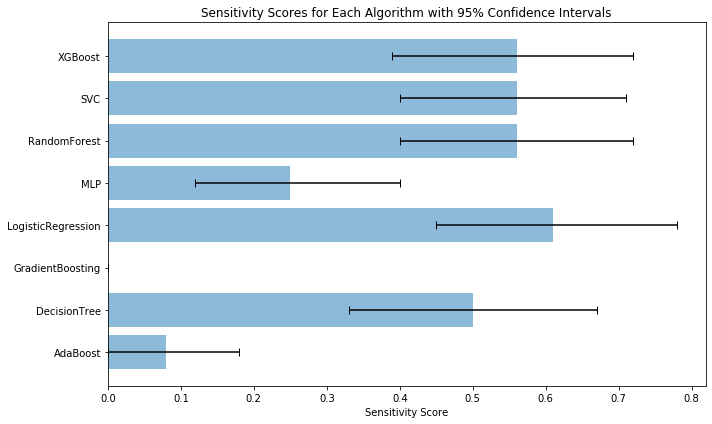

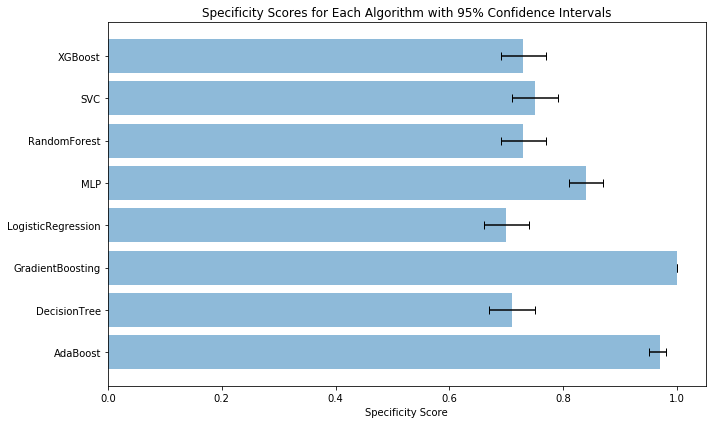

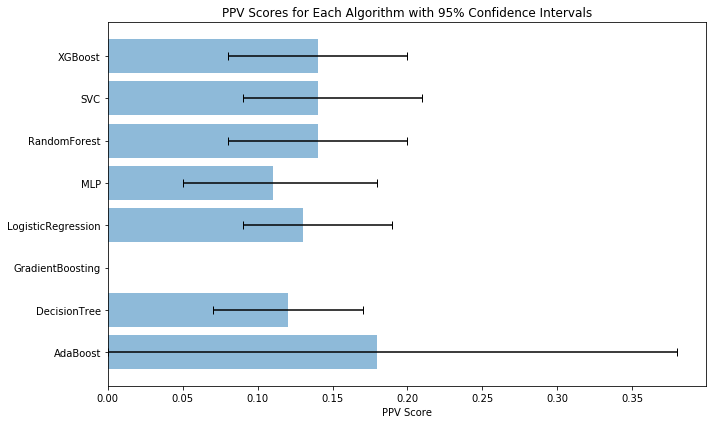

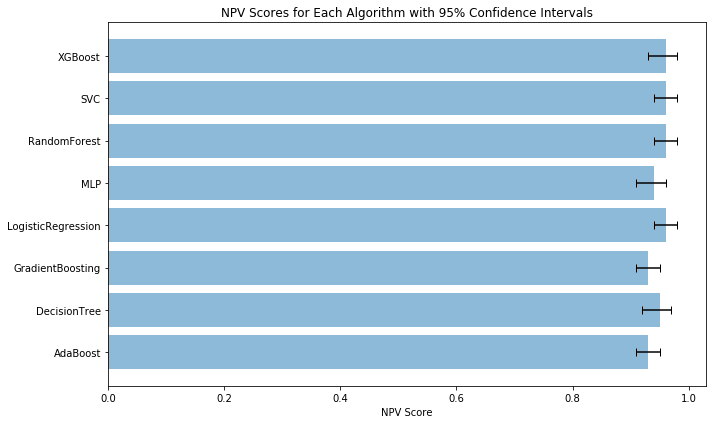

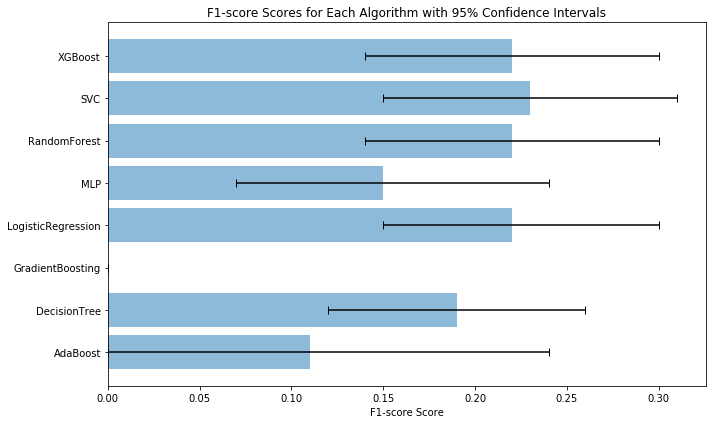

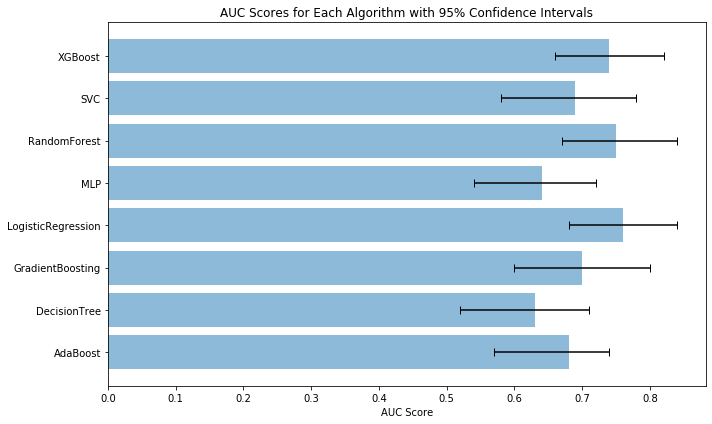

In [101]:
names = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1-score', 'AUC']

for i in range(len(table[0])):
    scores = []
    for row in table:
        median = (float(row[i].split(' ')[0]))
        low = (float(row[i].split(' ')[1].strip('()')))
        up = (float(row[i].split(' ')[3].rstrip(')')))
        new = [median, low, up]
        
        scores.append(new)
    
    plot_bar_score(scores, names[i])

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\sklearn\metrics\_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


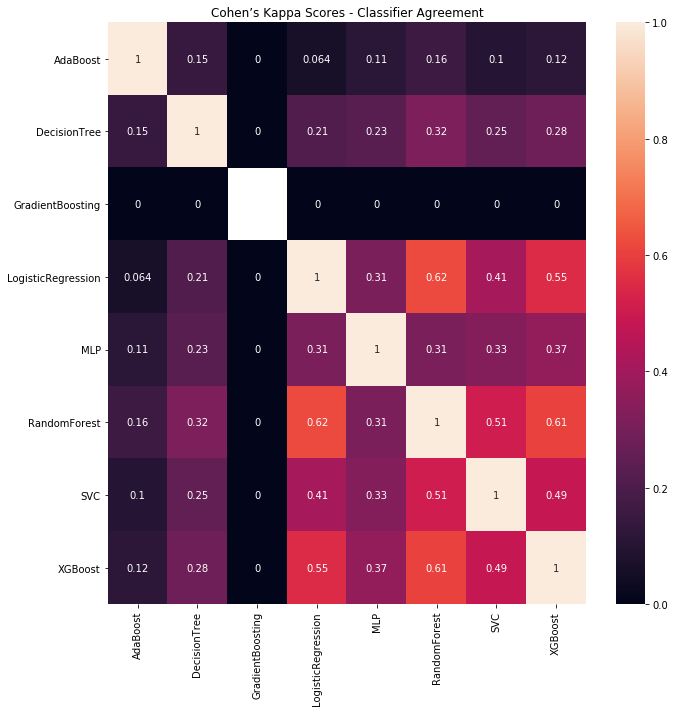

In [102]:
from sklearn.metrics import cohen_kappa_score
import seaborn as sns

kappa = pd.DataFrame(columns=index)

for i, model in enumerate(modelList):
    y1 = model.predict(X_test)
    intermList = []
    for mod2 in modelList:
        y2 = mod2.predict(X_test)
        
        score = cohen_kappa_score(y1, y2, Y_test)
        intermList.append(score)
        
    kappa.loc[i] = intermList
    kappa = kappa.rename(index={i: index[i]})

plt.figure(figsize=(10,10))
sns.heatmap(kappa, annot=True)
plt.title('Cohen’s Kappa Scores - Classifier Agreement')
plt.tight_layout()
plt.savefig('../reports/figures/cohens_kappa_scores.png')
plt.show()